In [1]:
import common
import plotting
import importlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import socket
import matplotlib.ticker as ticker

import matplotlib.style
matplotlib.style.use('classic')

# Show all columns and rows in a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print ("Base path is: " + plotting.base_path)

def slowdown_against_base(data, base):
    data["BFS"] = data["bfs"] / base["bfs"]
    data["PageRank"] = data["pagerank"] / base["pagerank"]
    data["WCC"] = data["wcc"] / base["wcc"]
    data["SSSP"] = data["sssp"] / base["sssp"]
    data["LCC"] = data["lcc"] / base["lcc"]
    return data


Base path is: /home/per/workspace/sortledton/src/figures/


In [2]:
# graphalytics inserts
pers_experiments = "num_threads_read == 0 and (hostname == 'scyper21')"

data_ins = common.import_gfe("view_graphalytics_inserts").query(pers_experiments).copy() # data from the experiments
data_ins["build_frequency"].fillna(pd.Timedelta(0), inplace=True) # replace NaT with 0, otherwise the records are ignored in the group by

data_ins = data_ins.query("((block_size == 512) and library == 'sortledton.1') or library != 'sortledton.1'")
data_ins = data_ins.query("(library == 'llama8-ref' and build_frequency == '0:0:10') or library != 'llama8-ref'")

# graphalytics load
data_load = common.import_gfe("view_graphalytics_load").query(pers_experiments).copy()
# shape the dataframe as data_ins
data_load["build_frequency"] = pd.Timedelta(0)
data_load["build_frequency_secs"] = np.NaN
data_load["num_snapshots_created"] = 0
data_load["num_threads_write"] = 0
data_load["block_size"] = -1

data = pd.concat([data_ins, data_load])


# Filter out validation runs they can be slightly less performant
data = data.query("validate_inserts == '0' and validate_output == '0'")

# Rename Libraries
rename_libraries = {
    "csr3": "CSR",
    "csr3-lcc-numa": "CSR-LCC",
    "sortledton.1": "Sortledton",
    "llama8-ref": "LLama",
    "g1_v6-ref-ignore-build": "G1",
    "livegraph3_ro": "Livegraph",
    "stinger7-ref": "Stinger",
    "teseo-lcc.12": "Teseo",
    "teseo-lcc-dv.12b": "Teseo dense",
    "sorted_vector_al.4": "Sorted Vector",
    "vector_al.3": "Unsorted Vector",
    "robin_hood_al.3": "Hashset",
    "robin_hood_sorted_vector_al.3": "Robin Hood Index",
    "tree_sorted_vector_al.3": "Tree Index",
    "edgeiter_sorted_vector_al.3": "Edge Iterator"
}

data["library"] = data["library"].map(lambda l: rename_libraries[l] if l in rename_libraries  else l)

In [3]:
# Grouping and aggregating

data_grouped_1 = data.groupby(["library", "graph", "algorithm"]) \
    .agg(completion_time=("median_secs", "median"), count=("median_secs", "count"))

data_grouped_1

completion_time  \
library                             graph          algorithm                    
CSR-LCC                             com-friendster bfs               0.982163   
                                                   cdlp            306.561424   
                                                   lcc              60.113414   
                                                   pagerank         31.077151   
                                                   sssp             59.444219   
                                                   wcc              10.109354   
                                    dota-league    bfs               0.000773   
                                                   cdlp              1.130063   
                                                   lcc              53.012164   
                                                   pagerank          0.101179   
                                                   sssp              0.249274   
                                                   wcc               0.023690   
                                    graph500-22    bfs               0.033145   
                                                   cdlp              5.570770   
                                                   lcc              12.339077   
                                                   pagerank          0.400319   
                                                   sssp              0.747900   
                                                   wcc               0.153263   
                                    graph500-24    bfs               0.131024   
                                                   cdlp             32.311592   
                                                   lcc              72.637627   
                                                   pagerank          2.692715   
                                                   sssp              4.854807   
                                                   wcc               0.926246   
                                    graph500-26    bfs               0.487549   
                                                   cdlp            143.385901   
                                                   lcc             476.783099   
                                                   pagerank         15.236883   
                                                   sssp             27.736315   
                                                   wcc               4.960557   
                                    uniform-24     bfs               0.148650   
                                                   cdlp             37.396524   
                                                   lcc               2.839330   
                                                   pagerank          3.335939   
                                                   sssp              6.472724   
                                                   wcc               1.169989   
                                    uniform-26     bfs               0.508873   
                                                   cdlp            141.641957   
                                                   lcc              13.202378   
                                                   pagerank         18.357686   
                                                   sssp             33.874291   
                                                   wcc               6.201792   
Edge Iterator                       com-friendster bfs               1.684588   
                                                   cdlp            238.260415   
                                                   lcc             161.388866   
                                                   pagerank         59.322476   
                                                   sssp             66.018406   
                                                   wcc              29.526731   
            

In [4]:
# Filter out libraries
libraries = ["sorted_vector_al.6", "sorted_vector_al.5", "sorted_vector_al.3", "csr4-lcc", "mb-csr.7", "mb-csr.3", "mb-csr.6", "mb-csr.4", "mb-csr.5", "Teseo", "Teseo dense", "single-numa-node-csr3-lcc", "single-numa-node-sorted-vector_al.2", "Edge Iterator", "CSR-LCC", "CSR", "Sortledton", "Hashset", "Sorted Vector", "Unsorted Vector", "Robin Hood Index", "Tree Index"]
libraries_query = " or ".join(list(map(lambda l: "library == '%s'" % l, libraries)))
data_grouped_2 = data_grouped_1.query(libraries_query)
data_grouped_2

completion_time  \
library                             graph          algorithm                    
CSR-LCC                             com-friendster bfs               0.982163   
                                                   cdlp            306.561424   
                                                   lcc              60.113414   
                                                   pagerank         31.077151   
                                                   sssp             59.444219   
                                                   wcc              10.109354   
                                    dota-league    bfs               0.000773   
                                                   cdlp              1.130063   
                                                   lcc              53.012164   
                                                   pagerank          0.101179   
                                                   sssp              0.249274   
                                                   wcc               0.023690   
                                    graph500-22    bfs               0.033145   
                                                   cdlp              5.570770   
                                                   lcc              12.339077   
                                                   pagerank          0.400319   
                                                   sssp              0.747900   
                                                   wcc               0.153263   
                                    graph500-24    bfs               0.131024   
                                                   cdlp             32.311592   
                                                   lcc              72.637627   
                                                   pagerank          2.692715   
                                                   sssp              4.854807   
                                                   wcc               0.926246   
                                    graph500-26    bfs               0.487549   
                                                   cdlp            143.385901   
                                                   lcc             476.783099   
                                                   pagerank         15.236883   
                                                   sssp             27.736315   
                                                   wcc               4.960557   
                                    uniform-24     bfs               0.148650   
                                                   cdlp             37.396524   
                                                   lcc               2.839330   
                                                   pagerank          3.335939   
                                                   sssp              6.472724   
                                                   wcc               1.169989   
                                    uniform-26     bfs               0.508873   
                                                   cdlp            141.641957   
                                                   lcc              13.202378   
                                                   pagerank         18.357686   
                                                   sssp             33.874291   
                                                   wcc               6.201792   
Edge Iterator                       com-friendster bfs               1.684588   
                                                   cdlp            238.260415   
                                                   lcc             161.388866   
                                                   pagerank         59.322476   
                                                   sssp             66.018406   
                                                   wcc              29.526731   
            

In [5]:
# Unstack
data_grouped = data_grouped_2.unstack("algorithm")[("completion_time")]

data_grouped.index.set_names(["Library", "Graph"], inplace=True)
data_grouped.columns.set_names("Algorithm", inplace=True)
data_grouped

Algorithm                                                 bfs        cdlp  \
Library                             Graph                                   
CSR-LCC                             com-friendster   0.982163  306.561424   
                                    dota-league      0.000773    1.130063   
                                    graph500-22      0.033145    5.570770   
                                    graph500-24      0.131024   32.311592   
                                    graph500-26      0.487549  143.385901   
                                    uniform-24       0.148650   37.396524   
                                    uniform-26       0.508873  141.641957   
Edge Iterator                       com-friendster   1.684588  238.260415   
                                    dota-league      0.001030    1.211908   
                                    graph500-24      0.216816   16.807736   
                                    uniform-24       0.193856   32.651022   
Hashset                             com-friendster   1.933455  260.331171   
                                    dota-league      0.001421    1.410329   
                                    graph500-24      0.232272   25.343940   
                                    uniform-24       0.196323   44.230886   
Robin Hood Index                    com-friendster  10.101373  253.635376   
                                    dota-league      0.010169    1.116069   
                                    graph500-24      1.420043   17.010503   
                                    uniform-24       1.357512   24.125501   
Sorted Vector                       com-friendster   1.517821  192.450146   
                                    dota-league      0.000771    1.122451   
                                    graph500-24      0.184935   16.106587   
                                    uniform-24       0.174998   40.792884   
Teseo                               com-friendster   1.447574  408.863313   
                                    dota-league      0.012365    1.632215   
                                    graph500-22      0.053875    4.725001   
                                    graph500-24      0.242851   27.760586   
                                    graph500-26      0.580025  134.955735   
                                    uniform-24       0.152768   42.481777   
                                    uniform-26       0.567068  162.830428   
Teseo dense                         dota-league      0.021470    1.324723   
                                    graph500-22      0.044152    3.286806   
                                    graph500-24      0.193392   13.957640   
                                    graph500-26      0.412326   63.481904   
                                    uniform-24       0.116996   23.710951   
                                    uniform-26       0.418195  112.942593   
Tree Index                          com-friendster  10.421664  258.118704   
                                    dota-league      0.009922    1.100814   
                                    graph500-24      1.572985   21.771193   
                                    uniform-24       1.526177   34.457266   
Unsorted Vector                     com-friendster   1.664409  233.362794   
                                    dota-league      0.001178    1.095732   
                                    graph500-24      0.218965   26.487475   
                                    uniform-24       0.186265   38.758474   
csr4-lcc                            graph500-24      0.136909   13.977643   
mb-csr.3                            dota-league      0.000997    1.193679   
                                    graph500-24      0.194907   28.499008   
                                    uniform-24       0.184003   32.070827   
mb-csr.4                            dota-league      0.000842    1.137341   
                                    graph500-24      0.134122   17.108383

In [6]:
# Compile CSR baseline out of NUMA optimized baseline and non NUMA optimized baseline
mb_csr = data_grouped.loc["mb-csr.6"]
gfe_csr = data_grouped.loc["CSR-LCC"]
min_csr = mb_csr.combine(gfe_csr, np.minimum)
min_csr

Algorithm,bfs,cdlp,lcc,pagerank,sssp,wcc
Graph,,,,,,
com-friendster,0.982163,195.124855,60.113414,30.737870,48.606802,10.109354
dota-league,0.000773,1.130063,48.139172,0.101179,0.249274,0.023690
graph500-22,NaN,NaN,NaN,NaN,NaN,NaN
graph500-24,0.131024,25.795513,51.023522,1.801857,4.612512,0.587119
graph500-26,NaN,NaN,NaN,NaN,NaN,NaN
uniform-24,0.148650,20.179249,2.839330,3.335939,6.472724,1.030069
uniform-26,NaN,NaN,NaN,NaN,NaN,NaN


## CSR vs Sorted Vector

In [7]:

contiguous_data = slowdown_against_base(data_grouped.copy(), min_csr)
contiguous_data = contiguous_data.loc["sorted_vector_al.6"]
contiguous_data = contiguous_data.drop(["sssp", "bfs", "wcc", "pagerank", "cdlp", "lcc"], axis=1)
contiguous_data

Algorithm,BFS,PageRank,WCC,SSSP,LCC
Graph,,,,,
com-friendster,1.358604,1.104634,1.836640,1.091299,0.968615
dota-league,0.983182,0.993887,1.007239,0.921251,0.987188
graph500-24,1.272515,1.179449,1.072415,0.799097,0.818774
uniform-24,1.079586,1.182992,1.052584,1.328614,1.201617


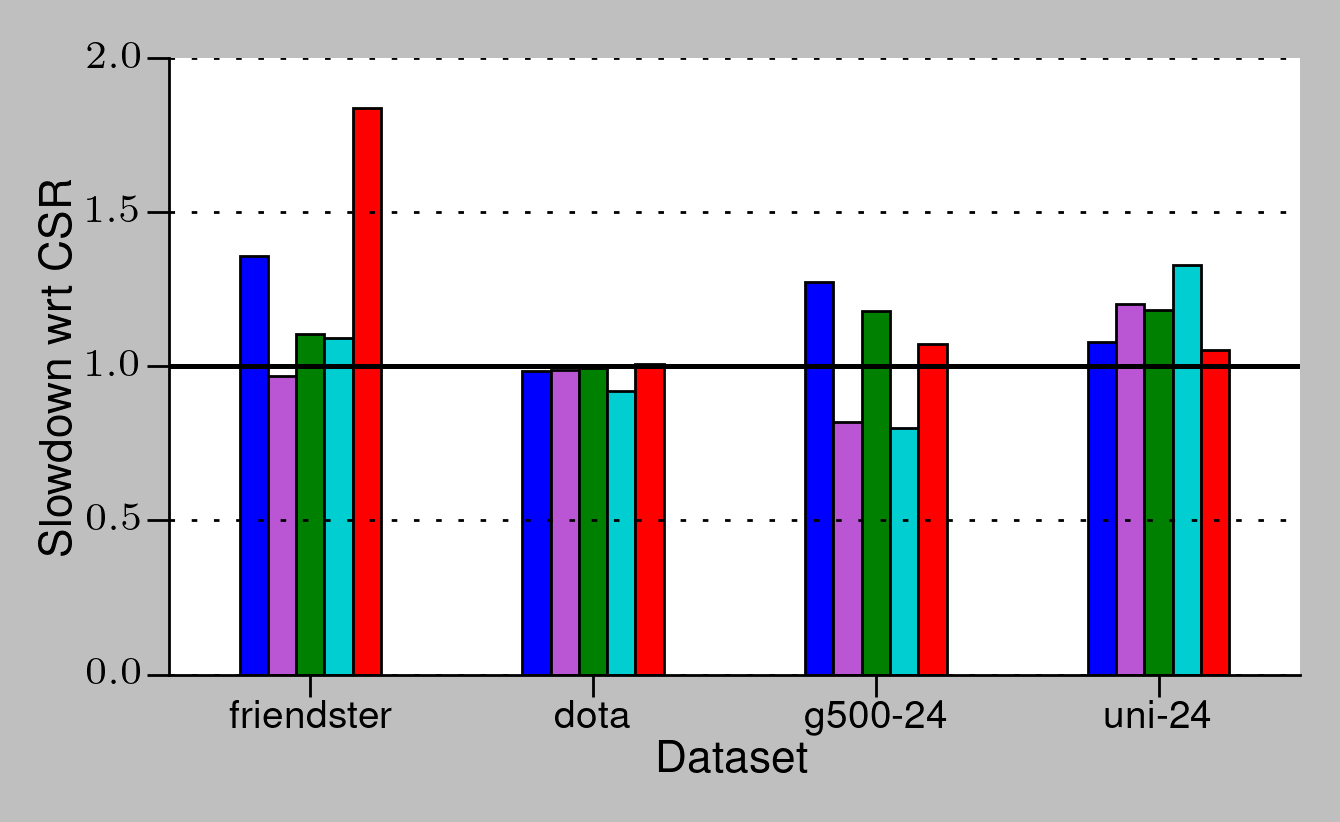

In [47]:
## FIGURE 2a
colormap=common.set_algorithm_colormap()

plotting.latexify()

p = contiguous_data.sort_values(axis=1, by='Algorithm').plot.bar(color=colormap, legend=None, linewidth=0.5)

plt.xticks(rotation=0)
positions = (0, 1, 2, 3)
x_labels = ("friendster", "dota", "g500-24", "uni-24")
plt.xticks(positions, x_labels)

plt.ylabel("Slowdown wrt CSR")
plt.xlabel("Dataset")

#p.set_ylim(0, 6)

plotting.add_line_on_1(plt)

plotting.format_axes(p)

plt.tight_layout()
plt.savefig(plotting.base_path + "/sequential-edge-layout-vs-vector-new.png", dpi=400)

## Dense vs Sparse Domain

In [9]:
# graphalytics inserts
pers_experiments = "num_threads_read == 0 and (hostname == 'scyper22')"

data = common.import_gfe("view_graphalytics_inserts").query(pers_experiments).copy() # data from the experiments
data["build_frequency"].fillna(pd.Timedelta(0), inplace=True) # replace NaT with 0, otherwise the records are ignored in the group by


# Filter out validation runs they can be slightly less performant
data = data.query("validate_inserts == '0' and validate_output == '0'")

# Rename Libraries
rename_libraries = {
    "csr3": "CSR",
    "csr3-lcc-numa": "CSR-LCC",
    "sortledton.1": "Sortledton",
    "llama8-ref": "LLama",
    "g1_v6-ref-ignore-build": "G1",
    "livegraph3_ro": "Livegraph",
    "stinger7-ref": "Stinger",
    "teseo-lcc.12": "Teseo",
    "teseo-lcc-dv.12b": "Teseo dense",
    "sorted_vector_al.4": "Sorted Vector",
    "vector_al.3": "Unsorted Vector",
    "robin_hood_al.3": "Hashset",
    "robin_hood_sorted_vector_al.3": "Robin Hood Index",
    "tree_sorted_vector_al.3": "Tree Index",
    "edgeiter_sorted_vector_al.3": "Edge Iterator"
}

data["library"] = data["library"].map(lambda l: rename_libraries[l] if l in rename_libraries  else l)

data_grouped_1 = data.groupby(["library", "graph", "algorithm"]) \
    .agg(completion_time=("median_secs", "median"), count=("median_secs", "count"))


# Filter out libraries
libraries = ["Teseo", "Teseo dense"]
libraries_query = " or ".join(list(map(lambda l: "library == '%s'" % l, libraries)))
data_grouped_2 = data_grouped_1.query(libraries_query)
data_grouped_2

data_grouped_dense_sparse = data_grouped_2.unstack("algorithm")[("completion_time")]

data_grouped_dense_sparse.index.set_names(["Library", "Graph"], inplace=True)
data_grouped_dense_sparse.columns.set_names("Algorithm", inplace=True)

In [10]:
# Compare Teseo dense vs Teseo sparse
dense_sparse = slowdown_against_base(data_grouped_dense_sparse.copy(), data_grouped_dense_sparse.loc["Teseo dense"])
dense_sparse = dense_sparse.drop(["sssp", "bfs", "wcc", "pagerank", "cdlp", "lcc"], axis=1)
dense_sparse = dense_sparse.loc["Teseo"]

In [11]:
# Filter out graphs
dense_sparse = dense_sparse.drop(["uniform-26", "graph500-22", "graph500-26"])
dense_sparse

Algorithm,BFS,PageRank,WCC,SSSP,LCC
Graph,,,,,
com-friendster,1.453355,2.323094,5.996484,1.492515,3.473198
dota-league,1.062657,1.698070,2.316799,1.885392,1.154303
graph500-24,0.857349,3.538002,4.539819,2.544154,2.746714
uniform-24,1.342010,2.342403,2.547448,1.799466,2.020347


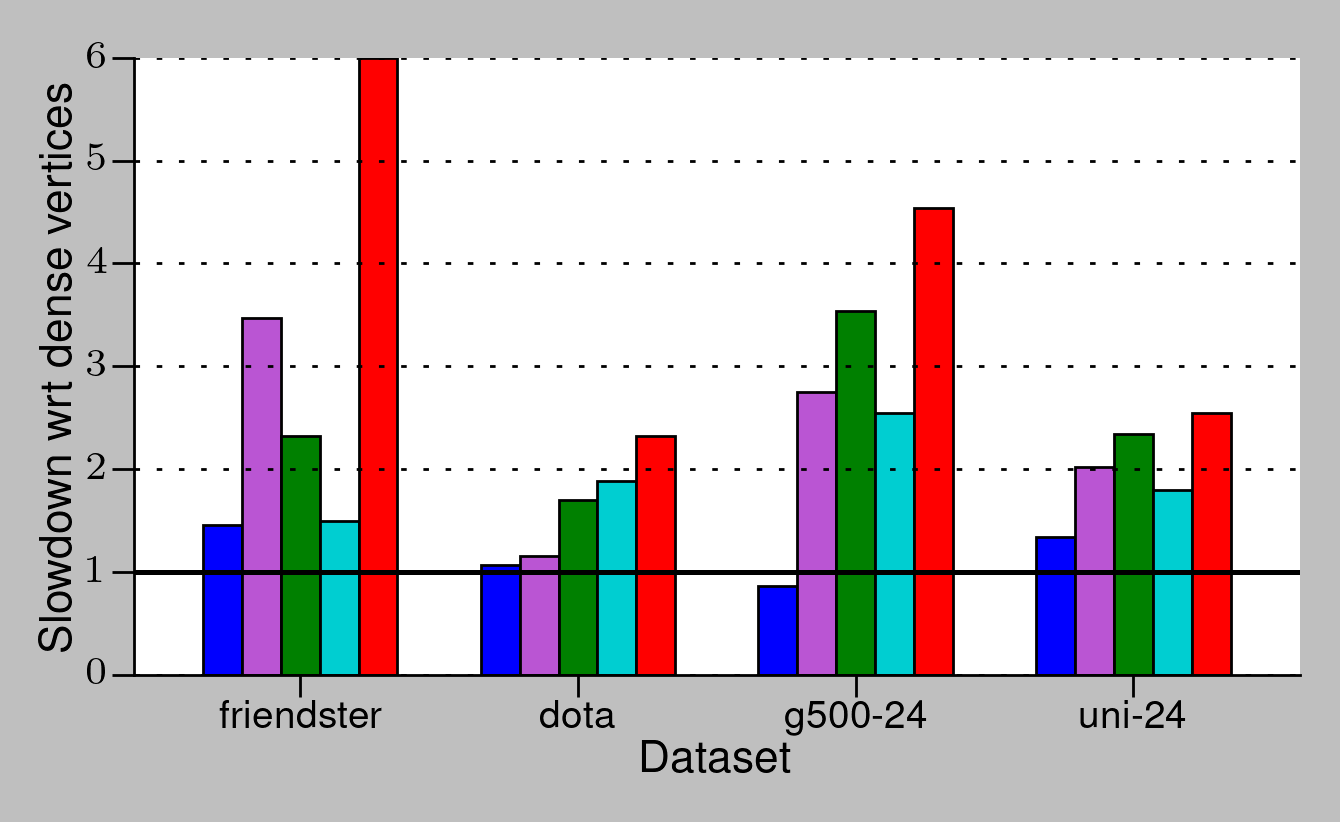

In [12]:
## FIGURE 2c
colormap=common.set_algorithm_colormap()
p = dense_sparse.sort_values(axis=1, by='Algorithm').plot.bar(width=0.7, linewidth=0.5, color=colormap, legend=None)

plotting.latexify()

plt.xticks(rotation=0)
plt.yticks()
x_labels = ("friendster", "dota", "g500-24", "uni-24")
plt.xticks(positions, x_labels)

plt.xlabel("Dataset")
plt.ylabel("Slowdown wrt dense vertices")

#plotting.add_line_on_1(plt)
plotting.format_axes(p)
plt.axhline(y = 1, color="black", linestyle = '-', linewidth=0.9)

plt.tight_layout()
plt.savefig(plotting.base_path + "dense-vs-sparse-vertex-domain-new.png", dpi=400)

## Blocked Edge Iterator

In [13]:
edge_iterator = slowdown_against_base(data_grouped.copy(), data_grouped.loc["Sorted Vector"])
edge_iterator = edge_iterator.drop(["sssp", "bfs", "wcc", "pagerank", "cdlp", "lcc"], axis=1)
edge_iterator = edge_iterator.loc["Edge Iterator"]
edge_iterator

Algorithm,BFS,PageRank,WCC,SSSP,LCC
Graph,,,,,
com-friendster,1.109873,1.689637,1.572401,1.242963,1.233726
dota-league,1.335279,2.314789,1.987934,1.493676,1.183481
graph500-24,1.172390,1.603010,1.523148,1.371000,1.337320
uniform-24,1.107761,1.849391,2.031743,1.309498,1.230854


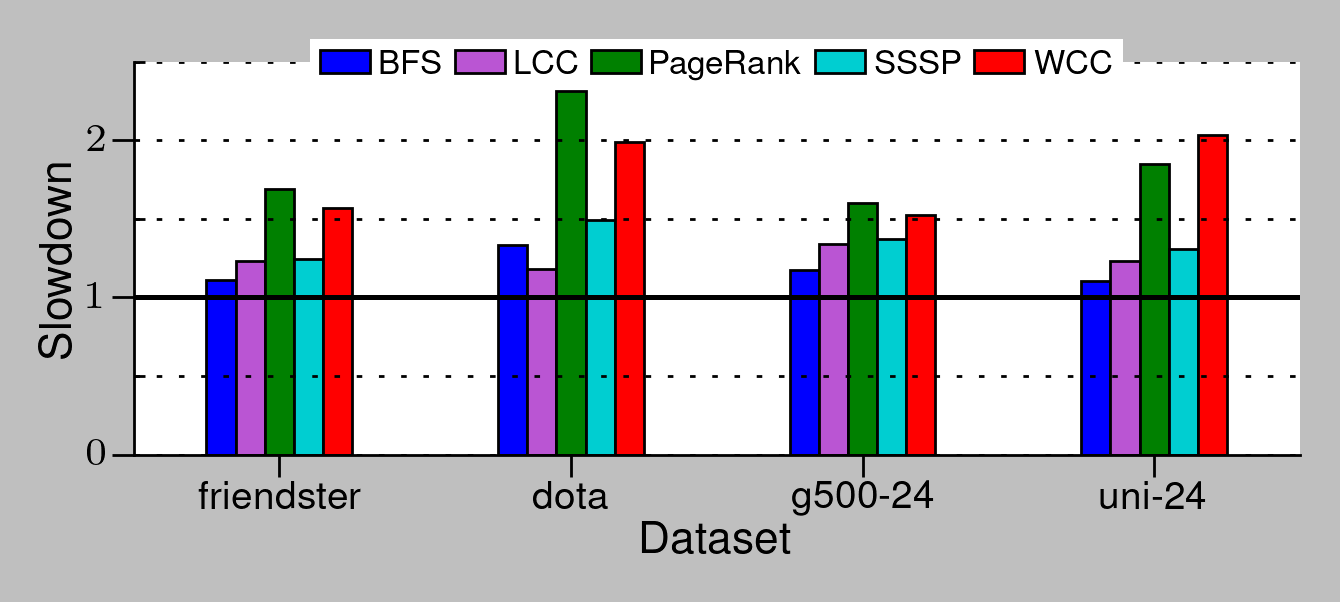

In [46]:
## FIGURE 5
plotting.latexify(fig_height=plotting.cm2inch(4))

colormap=common.set_algorithm_colormap()
p = edge_iterator.sort_values(axis=1, by='Algorithm').plot.bar(color=colormap, linewidth=0.5)


#plt.title("Sorted Vector with no access optimization")

plt.xlabel("Dataset")
plt.ylabel("Slowdown")

positions = (0, 1, 2, 3)
x_labels = ("friendster", "dota", "g500-24", "uni-24")
plt.xticks(positions, x_labels, rotation=0)

plt.legend(loc="upper center").get_frame().set_linewidth(0.0)

p.yaxis.set_major_locator(ticker.MultipleLocator(1))
p.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
p.yaxis.grid(which="minor")

plotting.format_axes(p)
plotting.add_line_on_1(plt)

plt.legend(loc="upper center", bbox_to_anchor=(0.5,1.1), ncol=5).get_frame().set_linewidth(0.0)

plt.tight_layout()
plt.savefig(plotting.base_path + "direct-access-vs-iterator-lambda-new.png", dpi=400)

### Single NUMA node

In these experiment, we used `numactlr -N 0 -m 0` to exclude NUMA effects. As we see the sorted vector implementation is still faster.

Although, the sorted vector implementation is labelled to be version .2 in these experiments, it has actually an optimized BFS implementation. However, it did not run on an optimized SSSP implementation so SSSP runs faster on a single NUMA node.

In [15]:
snn_contiguous_data = slowdown_against_base(data_grouped.copy(), data_grouped.loc["single-numa-node-csr3-lcc"])
snn_contiguous_data = snn_contiguous_data.loc["single-numa-node-sorted-vector_al.2"]
snn_contiguous_data = snn_contiguous_data.drop(["sssp", "bfs", "wcc", "pagerank", "cdlp", "lcc"], axis=1)
snn_contiguous_data

Algorithm,BFS,PageRank,WCC,SSSP,LCC
Graph,,,,,
graph500-24,1.697207,0.752017,0.553736,0.890566,NaN
uniform-24,1.316707,1.181756,0.810559,1.652470,NaN


Text(0, 0.5, 'Slowdown compared to CSR')

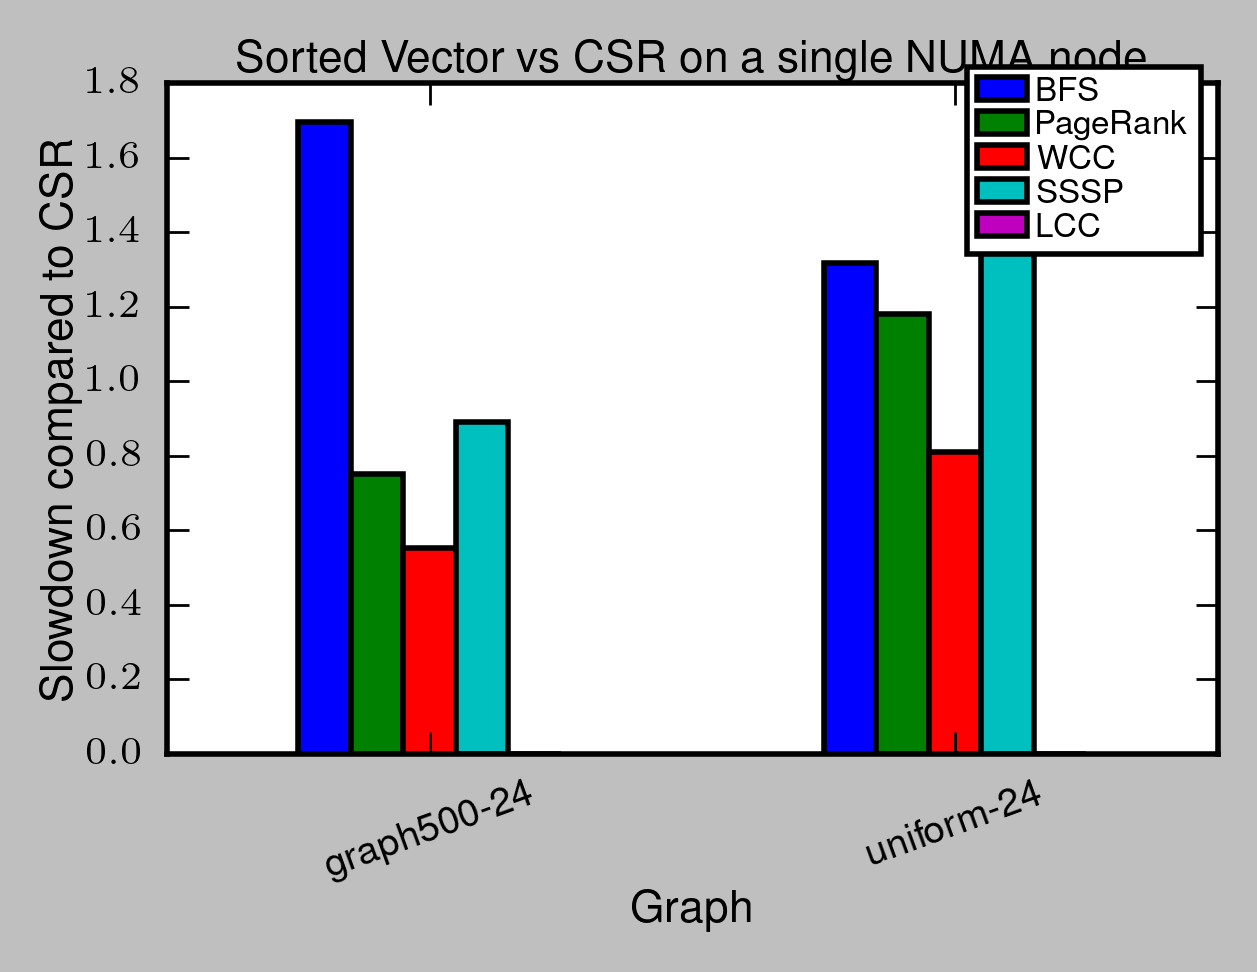

In [16]:
p = snn_contiguous_data.plot.bar()
plt.title("Sorted Vector vs CSR on a single NUMA node")
plt.xticks(rotation=20)
p.legend(bbox_to_anchor=(1.0, 1.05))
plt.ylabel("Slowdown compared to CSR")
#plt.ylim(0, 5)


## GFE Driver CSR vs MB CSR

We see differences between our CSR and the GFE Driver's CSR. 

Hypothesis 1: This is due to the fact that we use different make files to compile the algorithms.

Experiment 1: mb-csr.7 uses a WCC algorithm which is compiled with the same configuration as the GFE driver. We run it on graph500-24 as we see a big difference for this graph between our CSR and the GFE::CSR.

Observation 1: The ration between the two runtimes does not differ after this change (0.64 for mb-csr.7 and 0.633 for mb-csr.6)

Conclusion 1: This is not due to the different compilation systems used for the algorithms.

In [17]:
mb_csr = slowdown_against_base(data_grouped.copy(), data_grouped.loc["CSR-LCC"])
mb_csr = mb_csr.loc["mb-csr.7"]
#mb_csr = mb_csr.query("Graph == 'graph500-24'")
mb_csr = mb_csr.drop(["sssp", "bfs", "wcc", "pagerank", "cdlp", "lcc"], axis=1)
mb_csr

Algorithm,BFS,PageRank,WCC,SSSP,LCC
Graph,,,,,
graph500-24,1.086797,0.672559,0.639286,1.038613,0.738629


Text(0, 0.5, 'Slowdown compared to CSR')

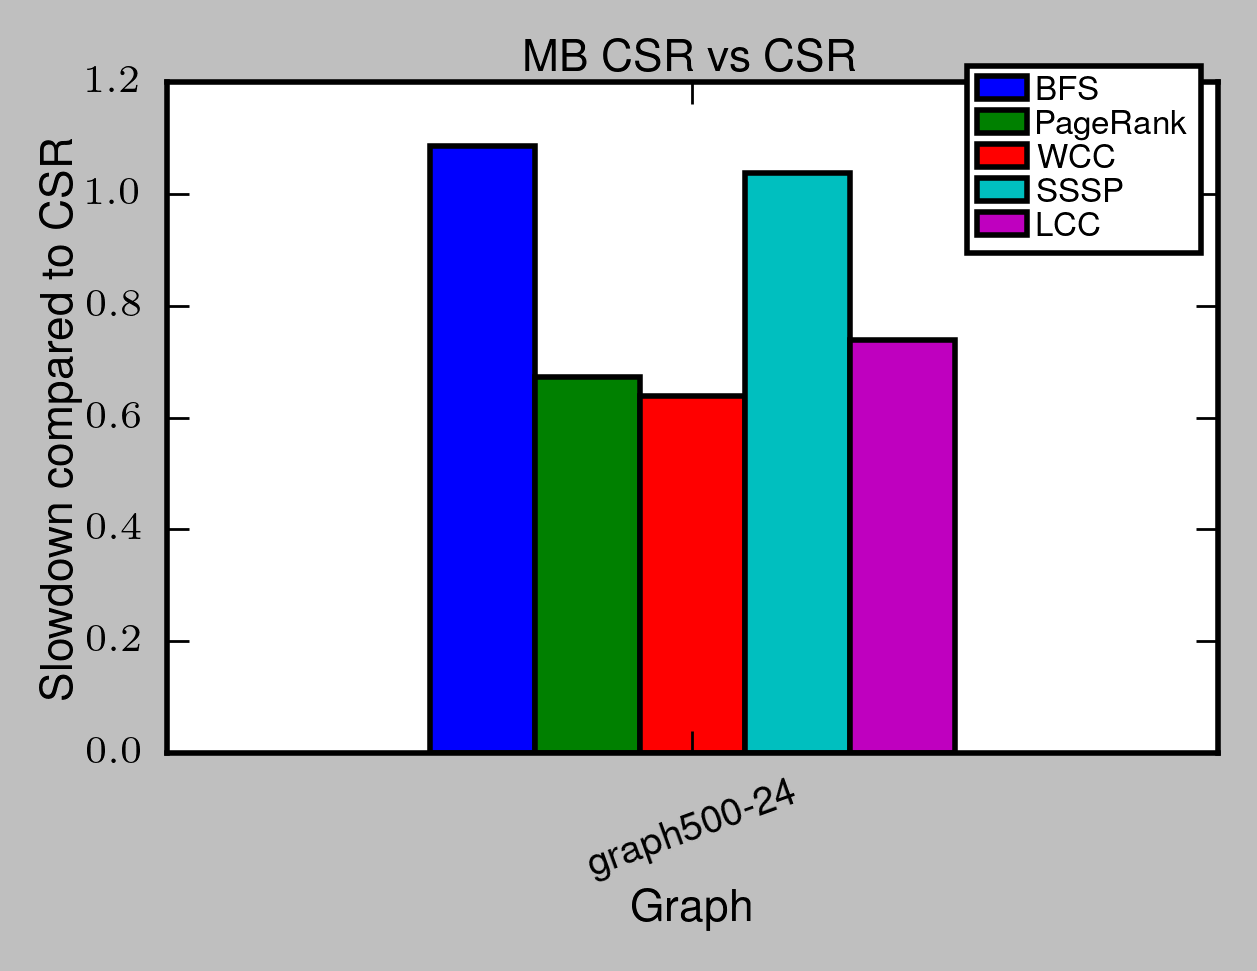

In [18]:
p = mb_csr.plot.bar()
plt.title("MB CSR vs CSR")
plt.xticks(rotation=20)
p.legend(bbox_to_anchor=(1.0, 1.05))
plt.ylabel("Slowdown compared to CSR")
#plt.ylim(0, 5)


## GFE Driver CSR vs MB CSR.4

The new MB CSR does not use locks and has an index containing exactly one offset per vertex.

In [19]:
mb_csr = slowdown_against_base(data_grouped.copy(), data_grouped.loc["CSR-LCC"])
mb_csr = mb_csr.loc["mb-csr.4"]
mb_csr = mb_csr.drop(["sssp", "bfs", "wcc", "pagerank", "cdlp", "lcc"], axis=1)
mb_csr

Algorithm,BFS,PageRank,WCC,SSSP,LCC
Graph,,,,,
dota-league,1.089263,1.463278,1.239764,1.514590,0.974003
graph500-24,1.023648,0.655584,0.621582,0.989781,1.342212
uniform-24,0.996307,1.005321,0.870655,1.542793,1.632968


Text(0, 0.5, 'Slowdown compared to CSR')

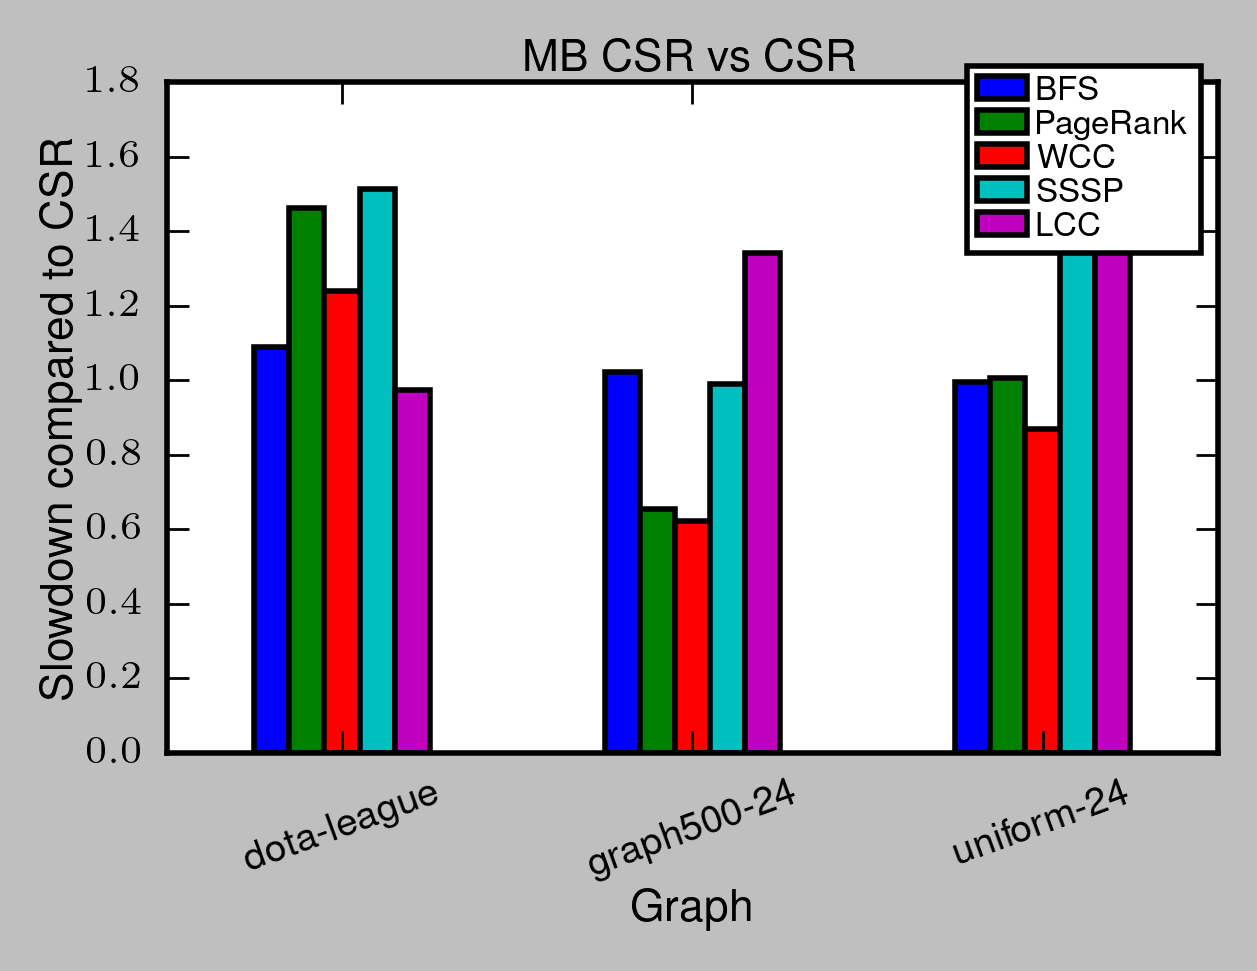

In [20]:
p = mb_csr.plot.bar()
plt.title("MB CSR vs CSR")
plt.xticks(rotation=20)
p.legend(bbox_to_anchor=(1.0, 1.05))
plt.ylabel("Slowdown compared to CSR")
#plt.ylim(0, 5)


### GFE CSR no timeout

I hope to explain the different in PageRank and WCC between the GFE CSR and CSR with the fact that the GFE uses a timeout service. 

Given that it is equally fast to a version with the timeout, I cannot confirum this idea.

In [21]:
gfe_csr_no_timout = slowdown_against_base(data_grouped.copy(), data_grouped.loc["CSR-LCC"])
gfe_csr_no_timout = gfe_csr_no_timout.loc["csr4-lcc"]
gfe_csr_no_timout = gfe_csr_no_timout.drop(["sssp", "bfs", "wcc", "pagerank", "cdlp", "lcc"], axis=1)
gfe_csr_no_timout

Algorithm,BFS,PageRank,WCC,SSSP,LCC
Graph,,,,,
graph500-24,1.044915,1.010516,1.012988,1.015029,1.117691


## Sorted vs Unsorted

In [22]:
sorted_data = slowdown_against_base(data_grouped.copy(), data_grouped.loc["Sorted Vector"])
# TODO add lcc once repaired?
sorted_data = sorted_data.drop(["sssp", "bfs", "wcc", "pagerank", "cdlp", "lcc", "LCC"], axis=1)
sorted_data = sorted_data.loc["Unsorted Vector"]
sorted_data

Algorithm,BFS,PageRank,WCC,SSSP
Graph,,,,
com-friendster,1.096578,1.231392,1.043210,1.060972
dota-league,1.527886,1.407797,1.201247,1.192017
graph500-24,1.184011,1.147761,1.082930,1.087112
uniform-24,1.064384,1.057049,1.042657,1.072940


NameError: name 'base_path' is not defined

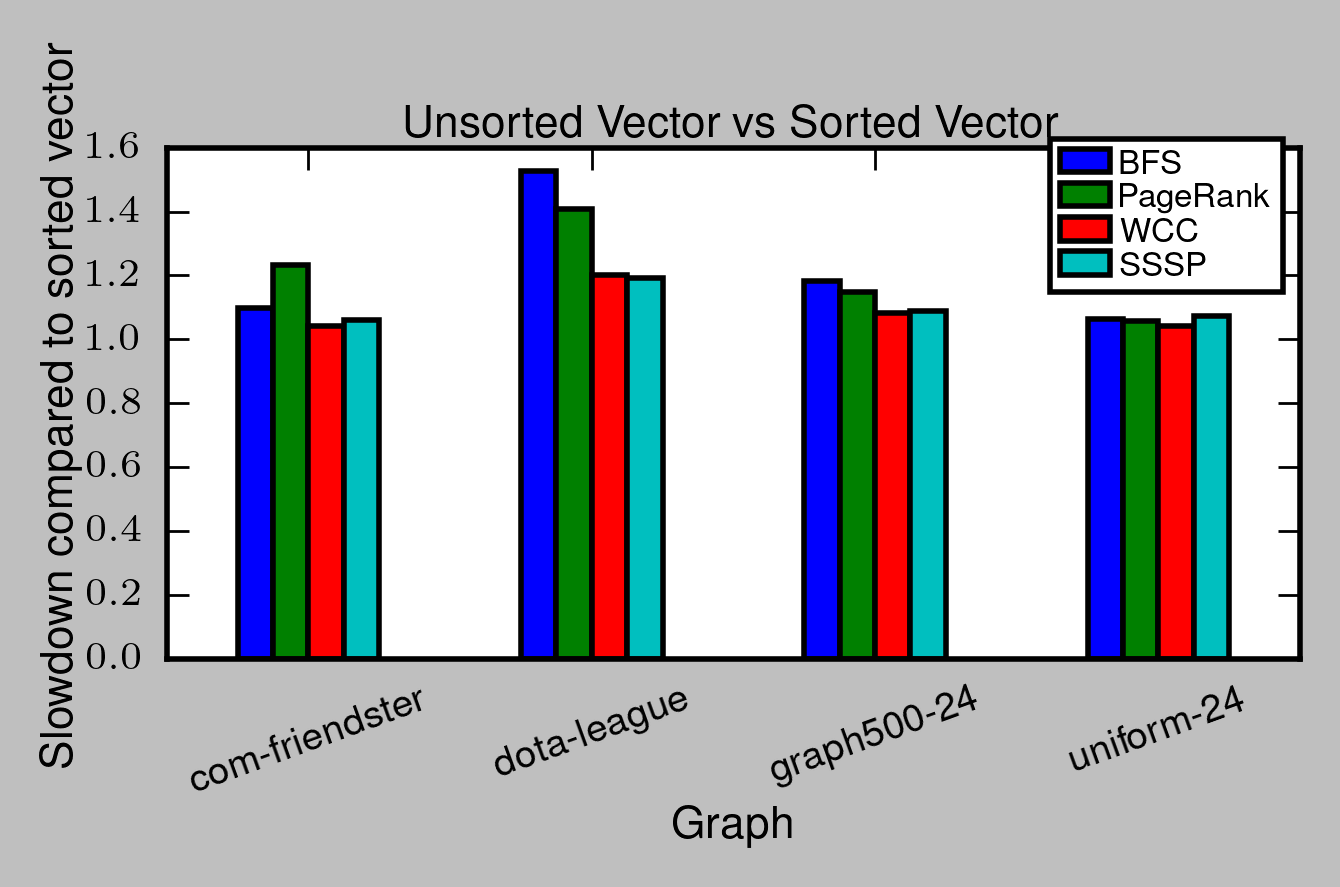

In [23]:
p = sorted_data.plot.bar()
plt.title("Unsorted Vector vs Sorted Vector")
plt.xticks(rotation=20)
plt.ylabel("Slowdown compared to sorted vector")
#plt.ylim(0, 5)
p.legend(bbox_to_anchor=(1.0, 1.05))
plt.tight_layout()
plt.savefig(base_path + "sorted-vs-unsorted-vector.png")

## Indices

In [ ]:
indices_data = slowdown_against_base(data_grouped.copy(), data_grouped.loc["Sorted Vector"])
indices_data = indices_data.drop(["sssp", "bfs", "wcc", "pagerank", "cdlp", "lcc", "BFS"], axis=1)
indices_data = indices_data.query("Library == 'Robin Hood Index' or Library == 'Tree Index'")
indices_data

In [ ]:
p = indices_data.plot.bar()
plt.title("Tree and hash based indices vs array based index")
plt.ylabel("Slowdown compared to array index")
plt.xticks(rotation=30)
p.legend(bbox_to_anchor=(1.0, 1.05))
#plt.ylim(0, 3)
plt.tight_layout()
plt.savefig(base_path + "tree-and-hash-set-indices.png")


## Hashsets as adjacency sets

In [ ]:
hashset_data = slowdown_against_base(data_grouped.copy(), data_grouped.loc["Edge Iterator"])
hashset_data = hashset_data.drop(["sssp", "bfs", "wcc", "pagerank", "cdlp", "lcc", "SSSP"], axis=1)
hashset_data = hashset_data.loc["Hashset"]
hashset_data

In [ ]:
p = hashset_data.plot.bar()
plt.title("Robin Hood Hashing for adjacency sets")
plt.xticks(rotation=30)
plt.ylabel("Slowdown compared to sorted vector")
plt.tight_layout()
plt.savefig(base_path + "sorted-vector-vs-hashset-al.png")